In [808]:
options(repr.plot.width=17, repr.plot.height=14)

library(plyr)
library(dplyr)
library(ggplot2)
library(cowplot)
library(hydroPSO)
library(data.table)
library(doParallel)
library(RColorBrewer)
library(MASS)
library(kernlab)
library(reshape2)
library(hydroPSO)

# Objective function
#f <- function(x) .2*sin(.2*x[[1]]*x[[2]]) + 1.5*sin(.2*x[[1]])
#f <- function(x) 2*sin(.1*x[[1]]*x[[2]])
f <- function(x) sin(2*x[[1]]) - .1*x[[2]]*cos(3*x[[2]])
#f <- function(x) sin(2*x[[1]]) - .1*x[[2]]*cos(3*x[[2]]) + .2*sin(x[[1]]*x[[2]])
#f <- function(x) x[[1]]^2 - 2*x[[2]] + cos(3*x[[1]])*sin(5*x[[2]])
f.noise <- 1e-7

# GP prior mean
prior.mu <- function(x) 0

# Plot values
plot.gps <- FALSE
x.limits <- c(0, 10)
y.limits <- c(-3, 3)
#x.limits <- c(-1, 1)
#y.limits <- c(-1, 1)
n.plot.breaks <- 50
n.color.breaks <- 20

x.breaks <- seq(x.limits[1], x.limits[2], diff(x.limits)/n.plot.breaks)
y.breaks <- seq(y.limits[1], y.limits[2], diff(y.limits)/n.plot.breaks)
grid <- expand.grid(x.breaks, y.breaks)
grid$f <- f(grid)
max.f <- grid[grid$f == max(grid$f),][1,]
min.f <- grid[grid$f == min(grid$f),][1,]
color.breaks <- seq(min.f$f - (max.f$f - min.f$f) * 0.1, 
                    max.f$f + (max.f$f - min.f$f) * 0.1, 
                    (max.f$f - min.f$f + 2*(max.f$f - min.f$f)*0.1)/n.color.breaks)

# OAK parameters
input.means <- c(5, 5)
input.vars <- c(2, 2)

# Other values
seed <- 293526
n.cores <- 8
n.points <- 100
n.points.test <- 1000
fixed.test <- TRUE
fixed.mse.test.data <- data.frame(x1=runif(n.points.test, x.limits[1], x.limits[2]), 
                                  x2=runif(n.points.test, y.limits[1], y.limits[2]))

# Kernel types: se, ak, ak1, ak2, oak.gaussian

# Performance measures: loglikelihood, test.mse
performance.measure <- 'test.mse'

In [809]:
# Function definitions

get.init.params <- function(kernel.type) {
    if (kernel.type == 'se') {
      initial.pars <- c(1, 1)
      lower.bounds <- c(.01, .1)
      upper.bounds <- c(10, 10)
    } else if (kernel.type == 'ak') {
      initial.pars <- c(1, 1, 1, 1)
      lower.bounds <- c(.01, .01, 0, 0)
      upper.bounds <- c(10, 10, 10, 10)
    } else if (kernel.type == 'ak1') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, .1)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'ak2') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, .1)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'oak.gaussian') {
      initial.pars <- c(1, 1, 1, 1, 1)
      lower.bounds <- c(.01, .01, 0, 0, 0)
      upper.bounds <- c(10, 10, 10, 10, 10)
    } else if (kernel.type == 'oak.gaussian0') {
      initial.pars <- c(1)
      lower.bounds <- c(0)
      upper.bounds <- c(10)
    } else if (kernel.type == 'oak.gaussian1') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, 0)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'oak.gaussian2') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, 0)
      upper.bounds <- c(10, 10, 10)
    }
    return(list(
        initial.pars=initial.pars,
        lower.bounds=lower.bounds,
        upper.bounds=upper.bounds
    ))
}

build.k <- function(type, l, sigma2) {
  if (type == 'se') {
    k <- function(x,x2) {
      kernel <- rbfdot(sigma=1/(2*l^2))
      k <- kernelMatrix(kernel, as.matrix(x), as.matrix(x2))
      return(sigma2*k)
    }
    return(k)
  } else if (type == 'ak') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[1]*(k1 + k2) + sigma2[2]*k1*k2)
    }
    return(k)
  } else if (type == 'ak1') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[1]*(k1 + k2))
    }
    return(k)
  } else if (type == 'ak2') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[2]*k1*k2)
    }
    return(k)
  } else if (type == 'oak.gaussian') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[1] + sigma2[2]*(k1 + k2) + sigma2[3]*k1*k2)
    }
    return(k)
  } else if (type == 'oak.gaussian0') {
    k <- function(x,x2) {
      return(matrix(sigma2[1], nrow=nrow(x), ncol=nrow(x2)))
    }
    return(k)
  } else if (type == 'oak.gaussian1') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[2]*(k1 + k2))
    }
    return(k)
  } else if (type == 'oak.gaussian2') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[3]*k1*k2)
    }
    return(k)
  }
}

calculate.regression.model <- function(X, y, k) {
  if (nrow(X) == 0) {
    K <- numeric(0)
    Ki <- K
  } else {
    K <- k(X,X)
    if (nrow(X) == 1) {
      Ki <- 1/(K + f.noise)
    } else {
      # ginv vs solve
      Ki <- solve(matrix(unlist(K),nrow=nrow(K)) + f.noise*diag(nrow(K)))
    }
  }
  
  fs <- function(Xs) {
    if (nrow(X) == 0)
      return(prior.mu(Xs))
    
    Ks <- k(Xs, X)
    # Ks <- matrix(unlist(Ks),nrow=nrow(Ks))
    return(prior.mu(Xs) + Ks %*% Ki %*% (y - prior.mu(Xs)))
  }
  
  
  sigma <- function(Xs) {
    Kss <- k(Xs, Xs)
    # Kss <- apply(Xs, 1, function(r) k(r,r))
    
    if (nrow(X) == 0)
      return(Kss)
    
    Ks <- k(Xs, X)
    S <- Kss - Ks %*% Ki %*% t(Ks)
    # if (Xs %in% observed.x && f.noise == 0)
    #   S <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S <- apply(S, 1:2, function(x) max(x,0)) # Numerical instability, (small) negative values should be 0
    return(S)
  }
  
  if (nrow(X) == 0) {
    best.x <- c(0,0)
    best.y <- prior.mu(c(0,0))
  } else {
    best.x <- X[which.max(y),]
    best.y <- max(y)
  }
  
  return(list(mean=fs, cov=sigma, best.x=best.x, best.y=best.y, K=K))
}

calculate.loglik <- function(gp.model, observed.x, observed.y) {
  Lu <- matrix(chol(gp.model$K), nrow=nrow(gp.model$K))
  Ll <- t(Lu)
  S1 <- forwardsolve(Ll, observed.y)
  S2 <- backsolve(Lu, S1)
  
  log.lik <- -sum(log(diag(Ll))) - .5 * observed.y %*% S2 - 0.5 * nrow(observed.x) + log(2*pi)
  return(log.lik)
}

calculate.test.mse <- function(gp.model, observed.x, observed.y) {
  if (fixed.test) {
    x.test <- fixed.mse.test.data
  } else {
    x.test <- data.frame(x1=runif(n.points.test, x.limits[1], x.limits[2]), 
                            x2=runif(n.points.test, y.limits[1], y.limits[2]))
  }
  
  y.test <- apply(x.test, 1, f)
  y.model <- gp.model$mean(x.test)
  
  mse <- mean((y.test - y.model)^2)
  return(mse)
} 

if (performance.measure == 'loglikelihood') {
  calculate.performance <- calculate.loglik
  fnscale <- -1
} else if (performance.measure == 'test.mse') {
  calculate.performance <- calculate.test.mse
  fnscale <- 1
}

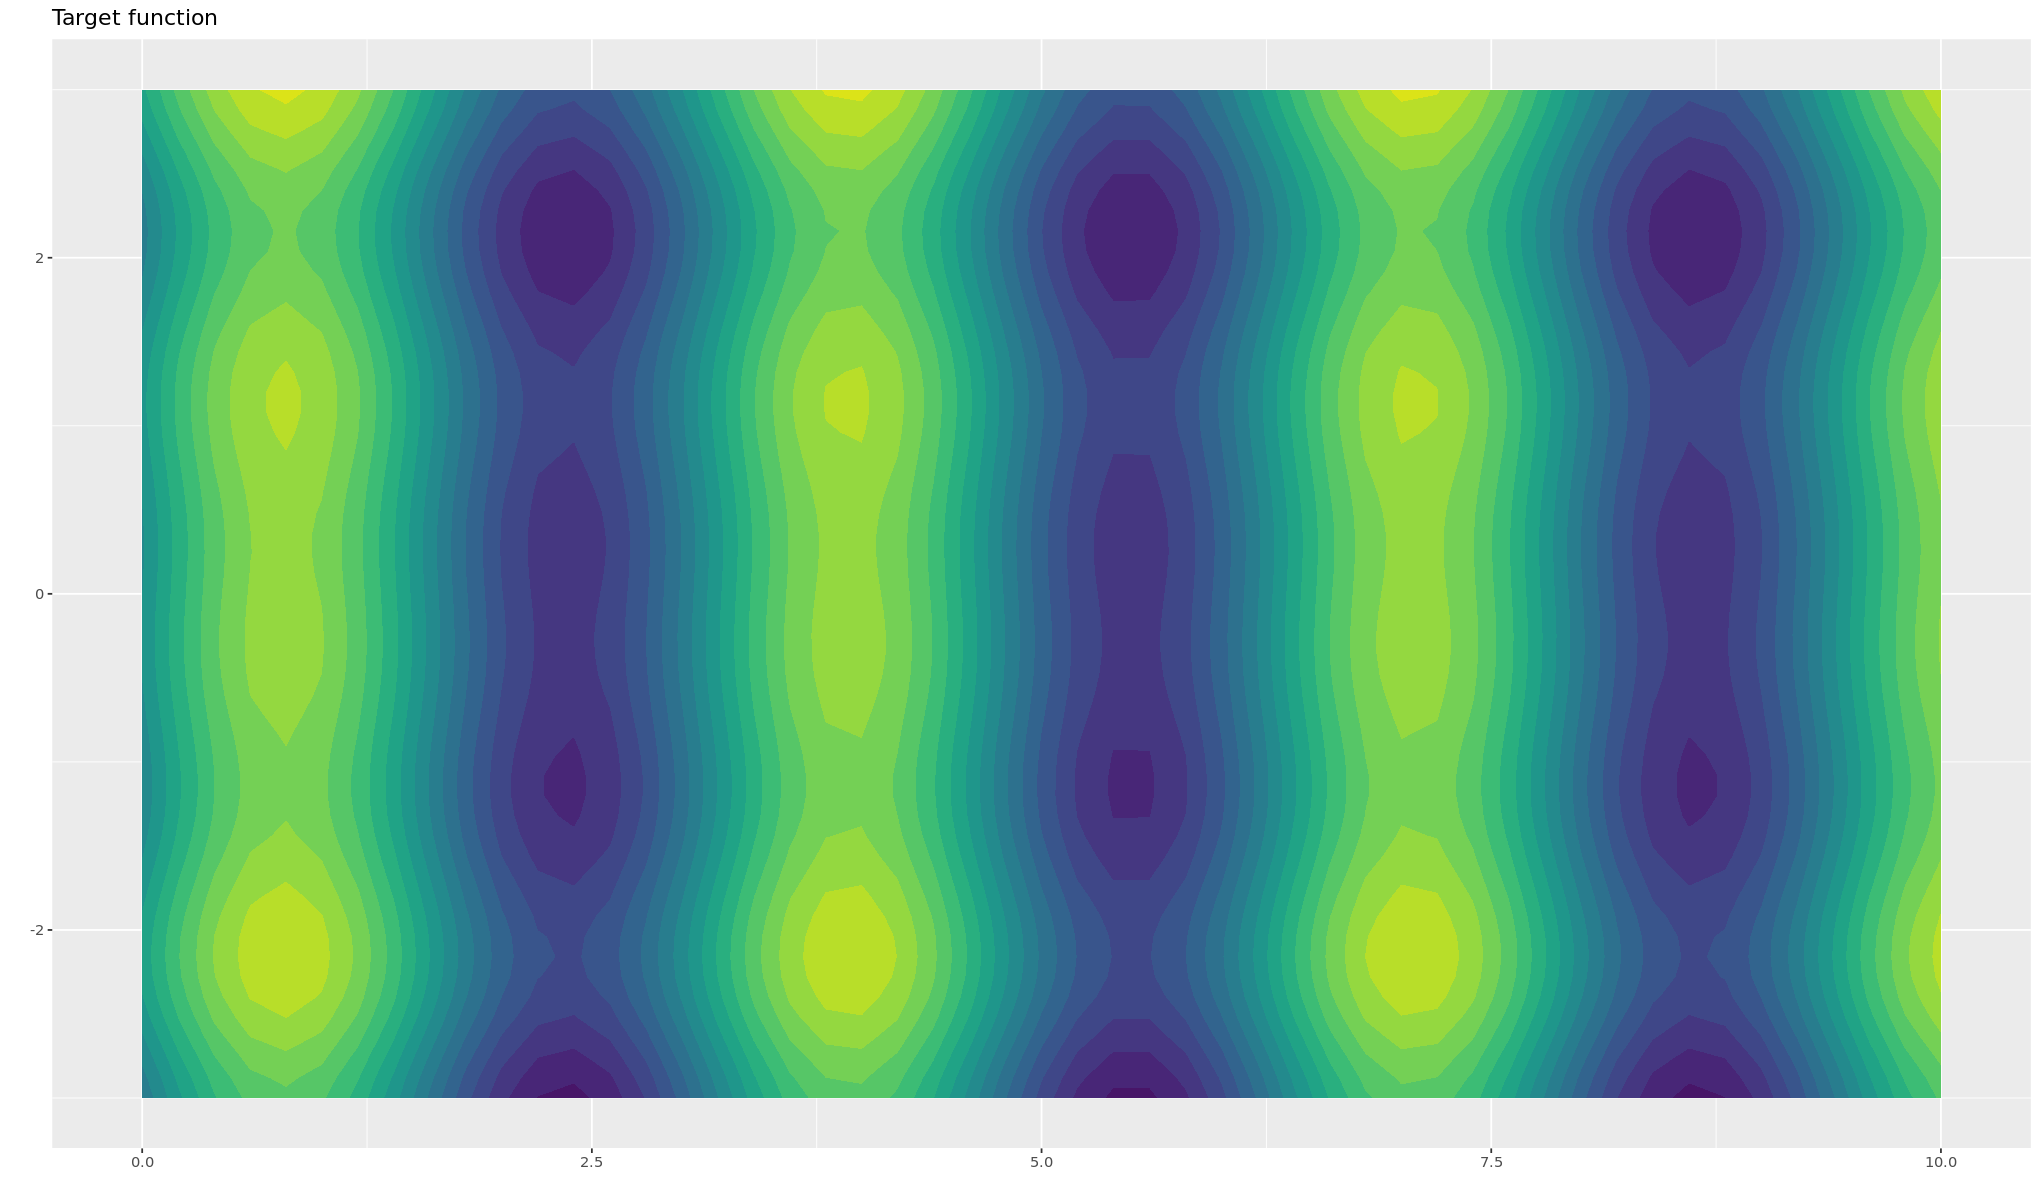

In [810]:
# Build target function plot

x1.plt <- x.breaks
x2.plt <- y.breaks
df.f <- expand.grid(x1.plt, x2.plt)
names(df.f) <- c('x', 'y')
x.plt <- df.f
df.f$z <- apply(df.f, 1, f)
names(x.plt) <- c('x1', 'x2')
xx <- x.plt

plt.f <- ggplot(df.f, aes(x=x, y=y, z=z)) + 
  geom_contour_filled(
    breaks=color.breaks
  ) +
  scale_fill_viridis_d(drop=FALSE) +
  theme(legend.position = "none") +
  xlab('') +
  ylab('') +
  ggtitle('Target function')

options(repr.plot.width=17, repr.plot.height=10)
plt.f

In [811]:
# Define hyperparameter optimization

calculate.params.ll <- function(pars, kernel.type, verbose=TRUE) {
  if (kernel.type == 'se') {
      l <- pars[1]
      sigma2 <- pars[2]
  } else if (kernel.type == 'ak') {
      l <- pars[1:2]
      sigma2 <- pars[3:4]
  } else if (kernel.type == 'ak1') {
      l <- pars[1:2]
      sigma2 <- pars[3]
  } else if (kernel.type == 'ak2') {
      l <- pars[1:2]
      sigma2 <- pars[3]
  } else if (kernel.type == 'oak.gaussian') {
      l <- pars[1:2]
      sigma2 <- pars[3:5]
  }
  
  k <- build.k(kernel.type, l, sigma2)
  
  observed.x <- data.frame(x1=runif(n.points, x.limits[1], x.limits[2]), 
                           x2=runif(n.points, y.limits[1], y.limits[2]))
  observed.y <- apply(observed.x, 1, f)
  
  gp.model <- calculate.regression.model(observed.x, observed.y, k)
  
  perf <- calculate.performance(gp.model, observed.x, observed.y)
  
  if (plot.gps) {
    cl <- makeCluster(n.cores)
    clusterExport(cl, ls(1))
    registerDoParallel(cl)
    
    df.f.model <- df.f
    df.f.model$z <- foreach(x=iter(xx, by='row'), .combine='c') %dopar% {
      gp.model$mean(data.frame(x))
    }
    
    stopCluster(cl)
    
    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(paste0('Gaussian process (Log-likelihood: ', perf, ')'))
  
    plt2 <- plot_grid(plt.f, plt, ncol=2, align='h')
    print(plt2)
  }
  
  if (performance.measure == 'loglikelihood') perf.name <- 'll'
  else if (performance.measure == 'test.mse') perf.name <- 'mse'
  if (verbose) {
      message(paste0('l=',paste0(l, collapse=','),
                     ', sigma2=', paste0(sigma2, collapse=','), ' (', perf.name, '=', perf, ')'), appendLF=FALSE )
  }
  return(perf)
}


# Squared Exponential kernel optimization

In [812]:
set.seed(13213)
kernel.type <- 'se'
optim.params <- get.init.params(kernel.type)

optim.result <- optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        temp=1000,
                        tmax=1000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')

l.se <- optim.result$par[1]
sigma2.se <- optim.result$par[2]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”
l=1, sigma2=1 (mse=0.00501356389923495)
l=1.001, sigma2=1 (mse=0.00747440580371804)
l=0.999, sigma2=1 (mse=0.00347479147789632)
l=1, sigma2=1.001 (mse=0.00587924521173233)
l=1, sigma2=0.999 (mse=0.0196258842358783)
l=0.01, sigma2=7.87331951207298 (mse=0.487835486941212)
l=0.011, sigma2=7.87331951207298 (mse=0.488266328625941)
l=0.01, sigma2=7.87331951207298 (mse=0.488886975891175)
l=0.01, sigma2=7.87431951207298 (mse=0.488907475870196)
l=0.01, sigma2=7.87231951207298 (mse=0.488818562886444)
l=0.673340274404246, sigma2=3.26791582398556 (mse=0.0384108108017063)
l=0.674340274404246, sigma2=3.26791582398556 (mse=0.0347649156962305)
l=0.672340274404246, sigma2=3.26791582398556 (mse=0.0633052390952395)
l=0.673340274404246, sigma2=3.26891582398556 (mse=0.0316895810697412)
l=0.673340274404246, sigma2=3.26691582398556 (mse=0.024753178091


Optimization results:
 Params=0.992498063980763,1.05207154490258
 Performance=0.0111840450611653


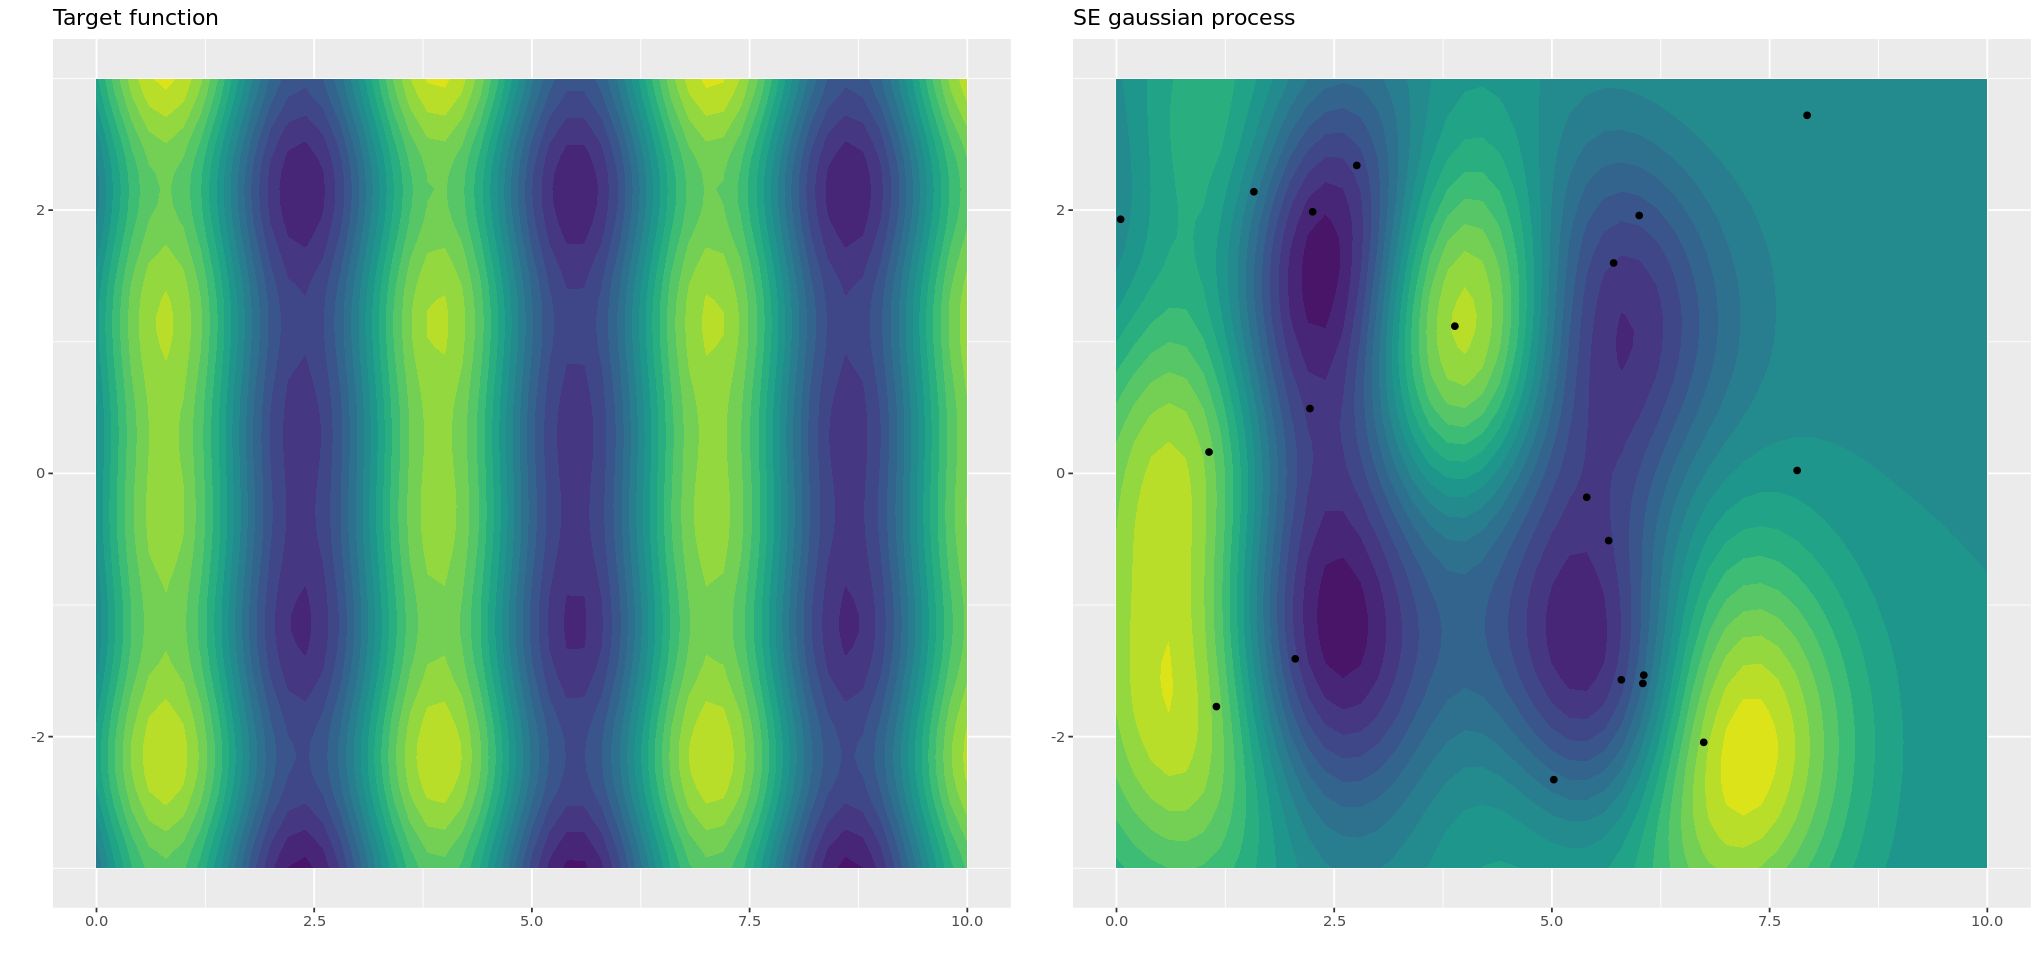

In [813]:
# Plot SE-GP with fitted hyperparameters

n.plot.train.points <- 20
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, x.limits[1], x.limits[2]), 
                         x2=runif(n.plot.train.points, y.limits[1], y.limits[2]))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('se', l.se, sigma2.se))
titles <- list('SE gaussian process')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    gp.model <- calculate.regression.model(observed.x, observed.y, k)

    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=8)
plt2 <- plot_grid(plotlist=plots, ncol=2, align='h')
print(plt2)

# Additive kernel optimization

In [818]:
set.seed(1603)
kernel.type <- 'ak'
optim.params <- get.init.params(kernel.type)

optim.result <- optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        parscale=rep(1,4),
                        temp=1000,
                        tmax=1000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')
cat(paste0(' Variance: ', 
           paste0(formatC(optim.result$par[3:4]*100/sum(optim.result$par[3:4]), 
                          format='f', digits=2), '%', collapse = ', '), 
         sep='\n'))

l.ak <- optim.result$par[1:2]
sigma2.ak <- optim.result$par[3:4]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”
l=1,1, sigma2=1,1 (mse=0.000945874754753268)
l=1.001,1, sigma2=1,1 (mse=0.000947599892444895)
l=0.999,1, sigma2=1,1 (mse=0.00236420098348873)
l=1,1.001, sigma2=1,1 (mse=0.000828451806293247)
l=1,0.999, sigma2=1,1 (mse=0.000616009648625579)
l=1,1, sigma2=1.001,1 (mse=0.000737420546045733)
l=1,1, sigma2=0.999,1 (mse=0.00087753360503333)
l=1,1, sigma2=1,1.001 (mse=0.00425812606123045)
l=1,1, sigma2=1,0.999 (mse=0.0014601344668743)
l=1.70830054552192,0.893778921166166, sigma2=1.0700565294938,0 (mse=1.43536087007766e-07)
l=1.70930054552192,0.893778921166166, sigma2=1.0700565294938,0 (mse=2.23038807089835e-08)
l=1.70730054552192,0.893778921166166, sigma2=1.0700565294938,0 (mse=4.98078396280883e-08)
l=1.70830054552192,0.894778921166166, sigma2=1.0700565294938,0 (mse=2.17202299490477e-07)
l=1.70830054552192,0.892778921166166, sigma2=1.0

l=1.08019526118355,0.987821510952684, sigma2=1.00803166172663,0.885361539209597 (mse=0.000777430129894823)
l=1.08119526118355,0.988821510952684, sigma2=1.00803166172663,0.885361539209597 (mse=0.000894450504507401)
l=1.08119526118355,0.986821510952684, sigma2=1.00803166172663,0.885361539209597 (mse=0.00072247860950916)
l=1.08119526118355,0.987821510952684, sigma2=1.00903166172663,0.885361539209597 (mse=0.000657892244024208)
l=1.08119526118355,0.987821510952684, sigma2=1.00703166172663,0.885361539209597 (mse=0.000876624729134986)
l=1.08119526118355,0.987821510952684, sigma2=1.00803166172663,0.886361539209597 (mse=0.00501387456351976)
l=1.08119526118355,0.987821510952684, sigma2=1.00803166172663,0.884361539209597 (mse=0.000599553808963743)
l=1.08119890076777,0.987822915423789, sigma2=1.00803121437243,0.885360948588106 (mse=0.000407169690073093)
l=1.08219890076777,0.987822915423789, sigma2=1.00803121437243,0.885360948588106 (mse=0.000759721292661465)
l=1.08019890076777,0.987822915423789, s

l=1.08173594124654,0.98777695368924, sigma2=1.0065914794149,0.884602007128156 (mse=0.0029749276364295)
l=1.08128178826695,0.987815822481531, sigma2=1.00780900848646,0.885398152763722 (mse=0.00107587957884822)
l=1.08228178826695,0.987815822481531, sigma2=1.00780900848646,0.885398152763722 (mse=0.000570069086693427)
l=1.08028178826695,0.987815822481531, sigma2=1.00780900848646,0.885398152763722 (mse=0.00112123885178606)
l=1.08128178826695,0.988815822481531, sigma2=1.00780900848646,0.885398152763722 (mse=0.000306002414109671)
l=1.08128178826695,0.986815822481531, sigma2=1.00780900848646,0.885398152763722 (mse=0.000976778811557545)
l=1.08128178826695,0.987815822481531, sigma2=1.00880900848646,0.885398152763722 (mse=0.00247684710949738)
l=1.08128178826695,0.987815822481531, sigma2=1.00680900848646,0.885398152763722 (mse=0.00419293154316147)
l=1.08128178826695,0.987815822481531, sigma2=1.00780900848646,0.886398152763722 (mse=0.000488129811154594)
l=1.08128178826695,0.987815822481531, sigma2=


Optimization results:
 Params=1.08119890289801,0.987822916245822,1.0080312141106,0.885360948242417
 Performance=0.00151042767491987
 Variance: 53.24%, 46.76%


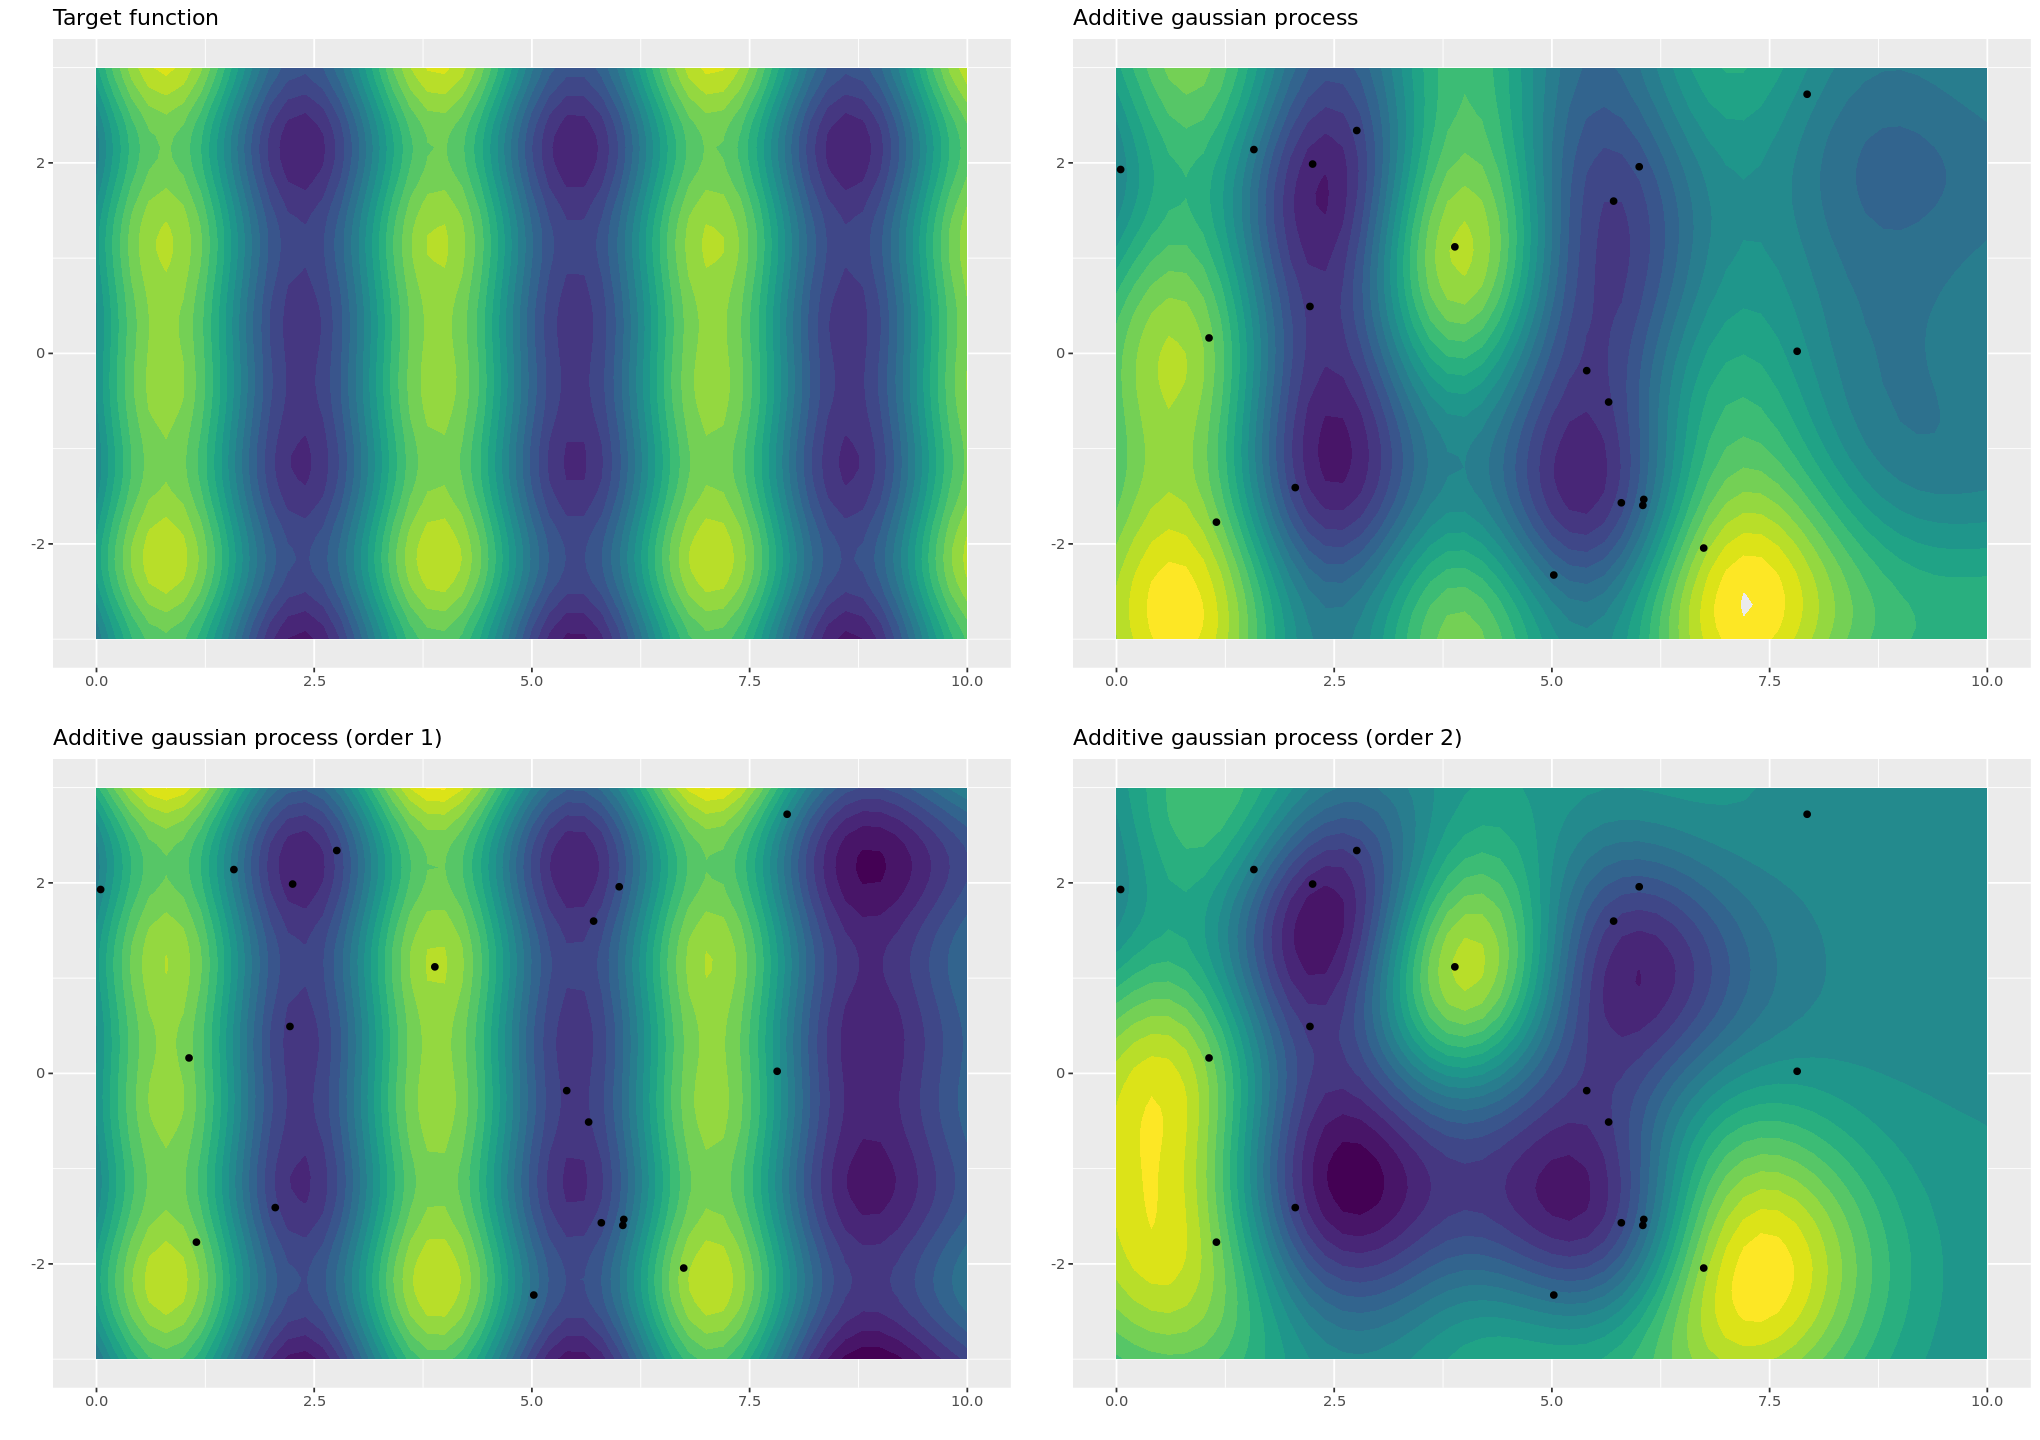

In [815]:
# Plot AK-GP with fitted hyperparameters

l.ak.plot <- l.ak
sigma2.ak.plot <- sigma2.ak
n.plot.train.points <- 20
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, x.limits[1], x.limits[2]), 
                         x2=runif(n.plot.train.points, y.limits[1], y.limits[2]))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('ak', l.ak.plot, sigma2.ak.plot),
                build.k('ak1', l.ak.plot, sigma2.ak.plot),
                build.k('ak2', l.ak.plot, sigma2.ak.plot))
titles <- list('Additive gaussian process', 'Additive gaussian process (order 1)', 'Additive gaussian process (order 2)')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    gp.model <- calculate.regression.model(observed.x, observed.y, k)

    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=12)
plt2 <- plot_grid(plotlist=plots, ncol=2, align='h')
print(plt2)

# Orthogonal additive kernel optimization

In [795]:
set.seed(1116231)
kernel.type <- 'oak.gaussian'
optim.params <- get.init.params(kernel.type)

optim.result <- optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        parscale=rep(10,5),
                        temp=10000,
                        tmax=10000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')
cat(paste0(' Variance: ', 
           paste0(formatC(optim.result$par[3:5]*100/sum(optim.result$par[3:5]), 
                          format='f', digits=2), '%', collapse = ', '), 
         sep='\n'))

l.oak.gaussian <- optim.result$par[1:2]
sigma2.oak.gaussian <- optim.result$par[3:5]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”
l=1,1, sigma2=1,1,1 (mse=4.48957411101014e-05)
l=1.01,1, sigma2=1,1,1 (mse=5.20846728144221e-05)
l=0.99,1, sigma2=1,1,1 (mse=5.05251315108848e-05)
l=1,1.01, sigma2=1,1,1 (mse=0.000258182868506231)
l=1,0.99, sigma2=1,1,1 (mse=5.44267296887519e-05)
l=1,1, sigma2=1.01,1,1 (mse=5.00784833265346e-05)
l=1,1, sigma2=0.99,1,1 (mse=6.13313115564969e-05)
l=1,1, sigma2=1,1.01,1 (mse=5.40301743556812e-05)
l=1,1, sigma2=1,0.99,1 (mse=5.87796174829997e-05)
l=1,1, sigma2=1,1,1.01 (mse=4.23718924074366e-05)
l=1,1, sigma2=1,1,0.99 (mse=4.41820434107694e-05)
l=0.992202293482313,0.01, sigma2=1.05626414114981,1.02374721563659,1.00905075501666 (mse=0.0108757423216202)
l=1.00220229348231,0.01, sigma2=1.05626414114981,1.02374721563659,1.00905075501666 (mse=0.00796886592276252)
l=0.982202293482313,0.01, sigma2=1.05626414114981,1.02374721563659,1.009050

l=0.996485850136294,0.553842099957488, sigma2=1.02535625359908,1.0007020281416,1.00407885439599 (mse=1.49216798800564e-08)
l=0.996485850136294,0.553842099957488, sigma2=1.02535625359908,1.0107020281416,1.01407885439599 (mse=1.31479063782476e-08)
l=0.996485850136294,0.553842099957488, sigma2=1.02535625359908,1.0107020281416,0.994078854395993 (mse=8.4996400029453e-09)
l=0.996485850136333,0.553842099957525, sigma2=1.02535625359907,1.0107020281412,1.00407885439599 (mse=3.43136054325948e-08)
l=1.00648585013633,0.553842099957525, sigma2=1.02535625359907,1.0107020281412,1.00407885439599 (mse=1.22096385414585e-08)
l=0.986485850136333,0.553842099957525, sigma2=1.02535625359907,1.0107020281412,1.00407885439599 (mse=1.4903163262007e-08)
l=0.996485850136333,0.563842099957525, sigma2=1.02535625359907,1.0107020281412,1.00407885439599 (mse=3.44276047811098e-08)
l=0.996485850136333,0.543842099957525, sigma2=1.02535625359907,1.0107020281412,1.00407885439599 (mse=7.62030802659008e-09)
l=0.99648585013633

l=0.996487580996747,0.55388444762614, sigma2=1.02535357055838,1.01068697156466,1.0140783675985 (mse=1.13379107373151e-08)
l=0.996487580996747,0.55388444762614, sigma2=1.02535357055838,1.01068697156466,0.994078367598496 (mse=1.51141367055911e-08)
l=0.996487580996879,0.553884447626128, sigma2=1.02535357055839,1.01068697156468,1.00407836759834 (mse=1.52639639142816e-08)
l=1.00648758099688,0.553884447626128, sigma2=1.02535357055839,1.01068697156468,1.00407836759834 (mse=1.96257250987575e-08)
l=0.986487580996878,0.553884447626128, sigma2=1.02535357055839,1.01068697156468,1.00407836759834 (mse=9.08330114021446e-09)
l=0.996487580996879,0.563884447626128, sigma2=1.02535357055839,1.01068697156468,1.00407836759834 (mse=3.65592778165518e-08)
l=0.996487580996879,0.543884447626128, sigma2=1.02535357055839,1.01068697156468,1.00407836759834 (mse=1.1538370976474e-08)
l=0.996487580996879,0.553884447626128, sigma2=1.03535357055839,1.01068697156468,1.00407836759834 (mse=1.00155972237025e-08)
l=0.99648758


Optimization results:
 Params=0.996487580996879,0.553884447626128,1.02535357055839,1.01068697156468,1.00407836759834
 Performance=1.64015781624998e-08
 Variance: 33.73%, 33.24%, 33.03%


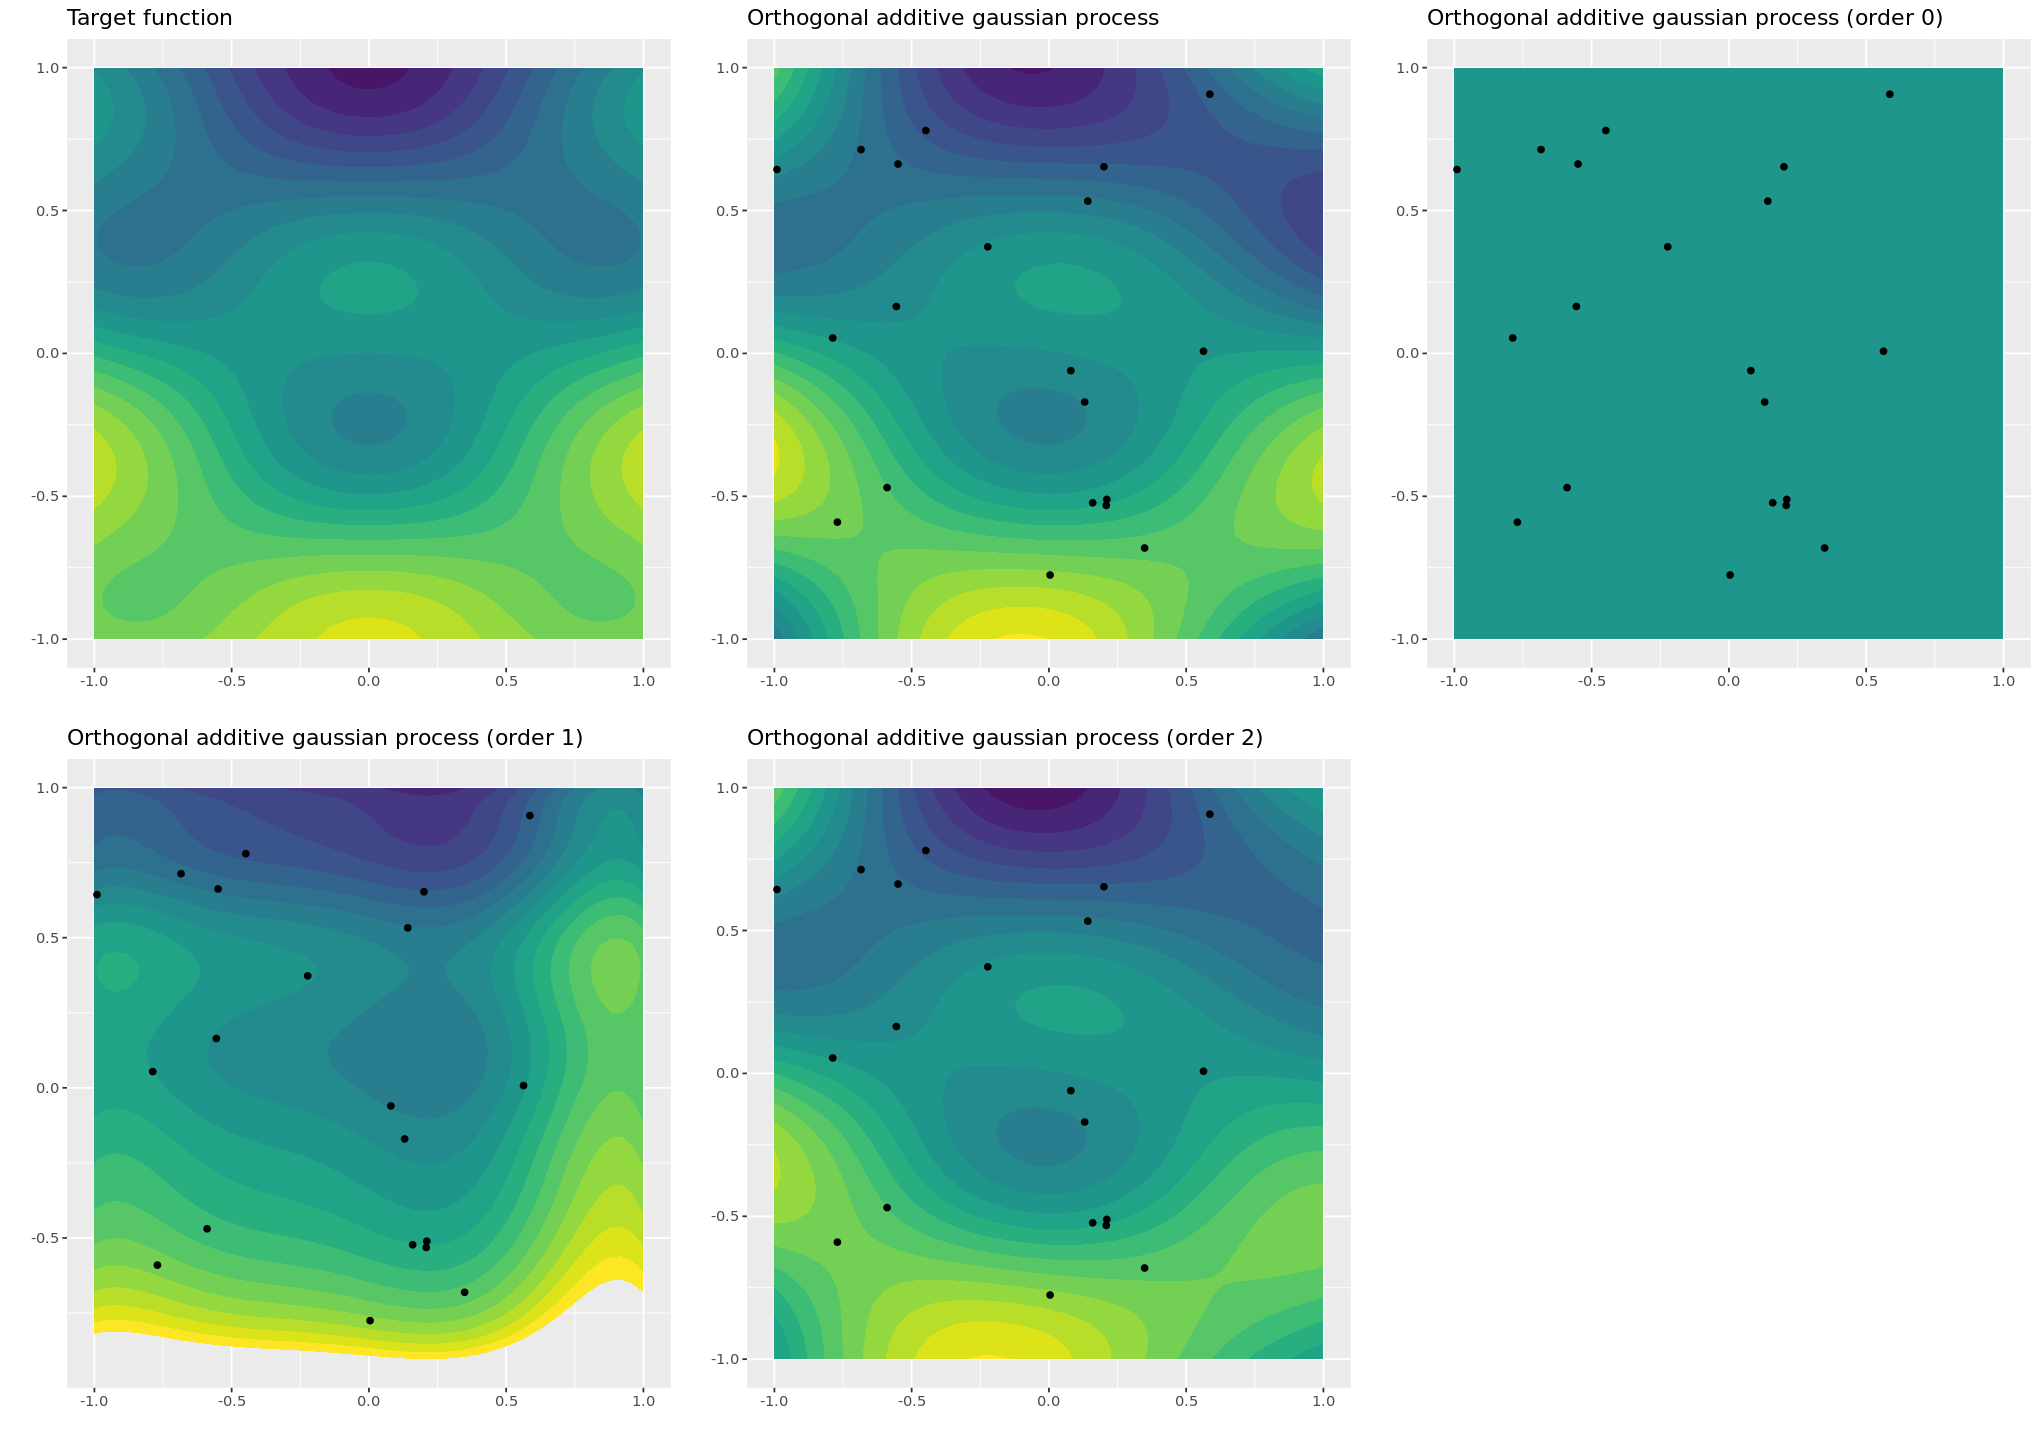

In [796]:
# Plot OAK-GP with fitted hyperparameters

l.oak.gaussian.plot <- l.oak.gaussian
sigma2.oak.gaussian.plot <- sigma2.oak.gaussian
n.plot.train.points <- 20
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, x.limits[1], x.limits[2]), 
                         x2=runif(n.plot.train.points, y.limits[1], y.limits[2]))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('oak.gaussian', l.oak.gaussian.plot, sigma2.oak.gaussian.plot),
                build.k('oak.gaussian0', l.oak.gaussian.plot, sigma2.oak.gaussian.plot), 
                build.k('oak.gaussian1', l.oak.gaussian.plot, sigma2.oak.gaussian.plot), 
                build.k('oak.gaussian2', l.oak.gaussian.plot, sigma2.oak.gaussian.plot))
titles <- list('Orthogonal additive gaussian process', 
               'Orthogonal additive gaussian process (order 0)', 
               'Orthogonal additive gaussian process (order 1)', 
               'Orthogonal additive gaussian process (order 2)')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    
    gp.model <- calculate.regression.model(observed.x, observed.y, k)
    
    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=12)
plt2 <- plot_grid(plotlist=plots, ncol=3, align='h')
print(plt2)

# Confidence intervals for hyperparameters

In [755]:
# CI for different seeds

par.list <- list(
    ak=c('l1', 'l2', 'sigma1', 'sigma2', 'mse'),
    oak.gaussian=c('l1', 'l2', 'sigma1', 'sigma2', 'sigma3', 'mse')
    )

parscale <- list(
    ak=100,
    oak.gaussian=50
)

df.result <- list()
experiment.seed <- 12
n.iters <- 20
for(kernel.type in c('ak', 'oak.gaussian')) {
    df.result[[kernel.type]] <- data.frame()
    for(seed in seq(n.iters)) {
        set.seed(seed*experiment.seed)
        optim.params <- get.init.params(kernel.type)
        rand.initial.pars <- sapply(seq(length(par.list[[kernel.type]])-1), 
                                    function(i) runif(1, optim.params$lower.bounds[i], optim.params$upper.bounds[i]))
                                    

        optim.result <- optim(par=optim.params$initial.pars,
                              method='SAN',
                              #method='L-BFGS-B',
                              fn=calculate.params.ll,
                              lower=optim.params$lower.bounds,
                              upper=optim.params$upper.bounds,
                              control=list(
                                pgtol=0,
                                fnscale=fnscale,
                                parscale=rep(parscale[[kernel.type]],length(optim.params$initial.pars)),
                                temp=1000,
                                tmax=1000,
                                maxit=10000
                                ),
                              kernel.type=kernel.type,
                              verbose=FALSE
                              )
        cat('\nOptimization results:', sep='\n')
        cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
        cat(paste0(' Performance=', optim.result$value), sep='\n')
        if (kernel.type == 'ak') {
          cat(paste0(' Variance: ', 
                       paste0(formatC(optim.result$par[3:4]*100/sum(optim.result$par[3:4]), 
                                      format='f', digits=2), '%', collapse = ', '), 
                     sep='\n'))

          l <- optim.result$par[1:2]
          sigma2 <- optim.result$par[3:4]
        } else if (kernel.type == 'oak.gaussian') {
          cat(paste0(' Variance: ', 
                       paste0(formatC(optim.result$par[3:5]*100/sum(optim.result$par[3:5]), 
                                      format='f', digits=2), '%', collapse = ', '), 
                     sep='\n'))

          l <- optim.result$par[1:2]
          sigma2 <- optim.result$par[3:5]
        } else if (kernel.type == 'se') {
          l <- optim.result$par[1]
          sigma2 <- optim.result$par[2]
        }  
        df.result[[kernel.type]] <- rbind(df.result[[kernel.type]], c(kernel.type, optim.result$par, optim.result$value))
    }
    names(df.result[[kernel.type]]) <- c('kernel.type', par.list[[kernel.type]])
}

print(df.result)

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.00996377192673,0.376899560961805,1.37181223688995,6.26064329674012
 Performance=2.21166504558543e-06
 Variance: 17.97%, 82.03%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.01354740232545,0.380238573295524,1.64097563249878,7.81989346405776
 Performance=2.10221196875531e-06
 Variance: 17.34%, 82.66%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.00294946450874,0.391987034295031,2.03634210605543,10
 Performance=2.09235383079227e-06
 Variance: 16.92%, 83.08%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02465878143355,0.379229523648263,1.59307954526887,7.55706988098137
 Performance=2.0861193611304e-06
 Variance: 17.41%, 82.59%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02531873970148,0.397620307917159,1.43364121692489,6.51864235049718
 Performance=2.35383955783554e-06
 Variance: 18.03%, 81.97%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.806890638399928,0.469866674057706,0.9095361763288,3.79161328940014
 Performance=3.17748504984039e-06
 Variance: 19.35%, 80.65%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.974781595506936,0.383280493386413,2.13486278025,10
 Performance=2.08663814952626e-06
 Variance: 17.59%, 82.41%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02597783416342,0.397480475144076,1.40952586755337,6.35697621919532
 Performance=2.36556183299192e-06
 Variance: 18.15%, 81.85%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02869040931798,0.381175535416178,1.49621003520444,7.0134109269989
 Performance=2.13423798407095e-06
 Variance: 17.58%, 82.42%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.0338518191372,0.380576657942926,1.47381118796007,6.89680668739845
 Performance=2.13043474349359e-06
 Variance: 17.61%, 82.39%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02486619684038,0.378954160293717,1.60927349972115,7.65433401642225
 Performance=2.07724175389232e-06
 Variance: 17.37%, 82.63%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.0052641667949,0.381724248460518,1.65579267498807,7.89245467700406
 Performance=2.13622088672243e-06
 Variance: 17.34%, 82.66%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.01225945099833,0.380537878624172,1.64290196967809,7.83039789519022
 Performance=2.10783475865625e-06
 Variance: 17.34%, 82.66%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.00276382462567,0.382047218975287,1.66250151794329,7.92198945544212
 Performance=2.14565542177486e-06
 Variance: 17.35%, 82.65%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02662202919357,0.378935622122821,1.60867011210745,7.66798761160506
 Performance=2.07392917687229e-06
 Variance: 17.34%, 82.66%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.00265215366154,0.383733139250955,1.74513510138848,8.37151157938095
 Performance=2.12711063890873e-06
 Variance: 17.25%, 82.75%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02508545431233,0.39801114910486,1.4347142840124,6.52503993260337
 Performance=2.35799994981516e-06
 Variance: 18.02%, 81.98%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.992778606451904,0.390433158347403,2.0424717654622,10
 Performance=2.09982522648178e-06
 Variance: 16.96%, 83.04%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.02558164886041,0.396455311903157,1.42097026737572,6.43080588768813
 Performance=2.34869960099847e-06
 Variance: 18.10%, 81.90%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.0050349864739,0.381737773671881,1.65655057919457,7.89578793220906
 Performance=2.13688212115002e-06
 Variance: 17.34%, 82.66%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500942208313066,0.515118707203502,0.97811702224098,0.496124493099143,3.52119803362949
 Performance=6.82420233886176e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500886747163802,0.514815417174988,0.978116956116812,0.496160762108648,3.52106170965521
 Performance=6.85044840645435e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1,1,1,1,1
 Performance=0.00312216358937755
 Variance: 33.33%, 33.33%, 33.33%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500912694845224,0.514957403948487,0.978116986451752,0.496143781759414,3.52112576375973
 Performance=6.83814824391014e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500892835583979,0.514848568747268,0.978116964339672,0.496156821584645,3.52107660616389
 Performance=6.84757522553304e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500894956034148,0.514860451046113,0.978116961356964,0.496155378288773,3.52108212914642
 Performance=6.84654383873322e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.504950389136104,0.529509799221454,0.978164422856661,0.495564339780003,3.52242496263021
 Performance=5.69647942612185e-06
 Variance: 19.58%, 9.92%, 70.50%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.504958123227935,0.529652360861321,0.978163922700641,0.495530174238235,3.52253941765742
 Performance=5.68815532045592e-06
 Variance: 19.58%, 9.92%, 70.50%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.50090921191434,0.51493488395875,0.978116994748397,0.496146639258931,3.52111498386939
 Performance=6.84007993869365e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500899401765574,0.51488469883574,0.978116977455491,0.496152470587617,3.52109307287551
 Performance=6.84444134446652e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500893252207088,0.514851278173785,0.978116961005591,0.496156426701018,3.5210781576489
 Performance=6.84733900073322e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.502954240680203,0.51409428883156,0.978150880578968,0.496921949645264,3.51790040689953
 Performance=6.85419984989413e-06
 Variance: 19.59%, 9.95%, 70.46%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500884445618396,0.514802653939263,0.978116975273101,0.496162319097595,3.52105587802281
 Performance=6.85155234271255e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.503968862086868,0.513835378158282,0.978167335687101,0.497282112939089,3.5164063931176
 Performance=6.85096643654417e-06
 Variance: 19.60%, 9.96%, 70.44%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500897904043912,0.514871876197391,0.978116973114774,0.496154255922955,3.52108624452171
 Performance=6.84552845440214e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1,1,1,1,1
 Performance=0.00312216358937755
 Variance: 33.33%, 33.33%, 33.33%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500886243945094,0.514811146852136,0.978116953495156,0.496161388792228,3.52105935604652
 Performance=6.85080952662939e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1,1,1,1,1
 Performance=0.00312216358937755
 Variance: 33.33%, 33.33%, 33.33%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.500924237575884,0.515020102126631,0.978116990689392,0.496136294658412,3.52115384330781
 Performance=6.83272287707261e-06
 Variance: 19.58%, 9.93%, 70.49%


Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.503584797838566,0.513926215045392,0.978161123380229,0.497146771336162,3.51696767648999
 Performance=6.85256796334378e-06
 Variance: 19.59%, 9.96%, 70.45%
$ak
   kernel.type                l1                l2           sigma1
1           ak  1.00996377192673 0.376899560961805 1.37181223688995
2           ak  1.01354740232545 0.380238573295524 1.64097563249878
3           ak  1.00294946450874 0.391987034295031 2.03634210605543
4           ak  1.02465878143355 0.379229523648263 1.59307954526887
5           ak  1.02531873970148 0.397620307917159 1.43364121692489
6           ak 0.806890638399928 0.469866674057706  0.9095361763288
7           ak 0.974781595506936 0.383280493386413    2.13486278025
8           ak  1.02597783416342 0.397480475144076 1.40952586755337
9           ak  1.02869040931798 0.381175535416178 1.49621003520444
10          ak   1.0338518191372 0.380576657942926 1.47381118796007
11          ak  1.02486619684038 0.378954160293717 1.60927349

In [756]:
df.result

kernel.type,l1,l2,sigma1,sigma2,mse
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ak,1.00996377192673,0.376899560961805,1.37181223688995,6.26064329674012,2.21166504558543e-06
ak,1.01354740232545,0.380238573295524,1.64097563249878,7.81989346405776,2.10221196875531e-06
ak,1.00294946450874,0.391987034295031,2.03634210605543,10,2.09235383079227e-06
ak,1.02465878143355,0.379229523648263,1.59307954526887,7.55706988098137,2.0861193611304e-06
ak,1.02531873970148,0.397620307917159,1.43364121692489,6.51864235049718,2.35383955783554e-06
ak,0.806890638399928,0.469866674057706,0.9095361763288,3.79161328940014,3.17748504984039e-06
ak,0.974781595506936,0.383280493386413,2.13486278025,10,2.08663814952626e-06
ak,1.02597783416342,0.397480475144076,1.40952586755337,6.35697621919532,2.36556183299192e-06
ak,1.02869040931798,0.381175535416178,1.49621003520444,7.0134109269989,2.13423798407095e-06


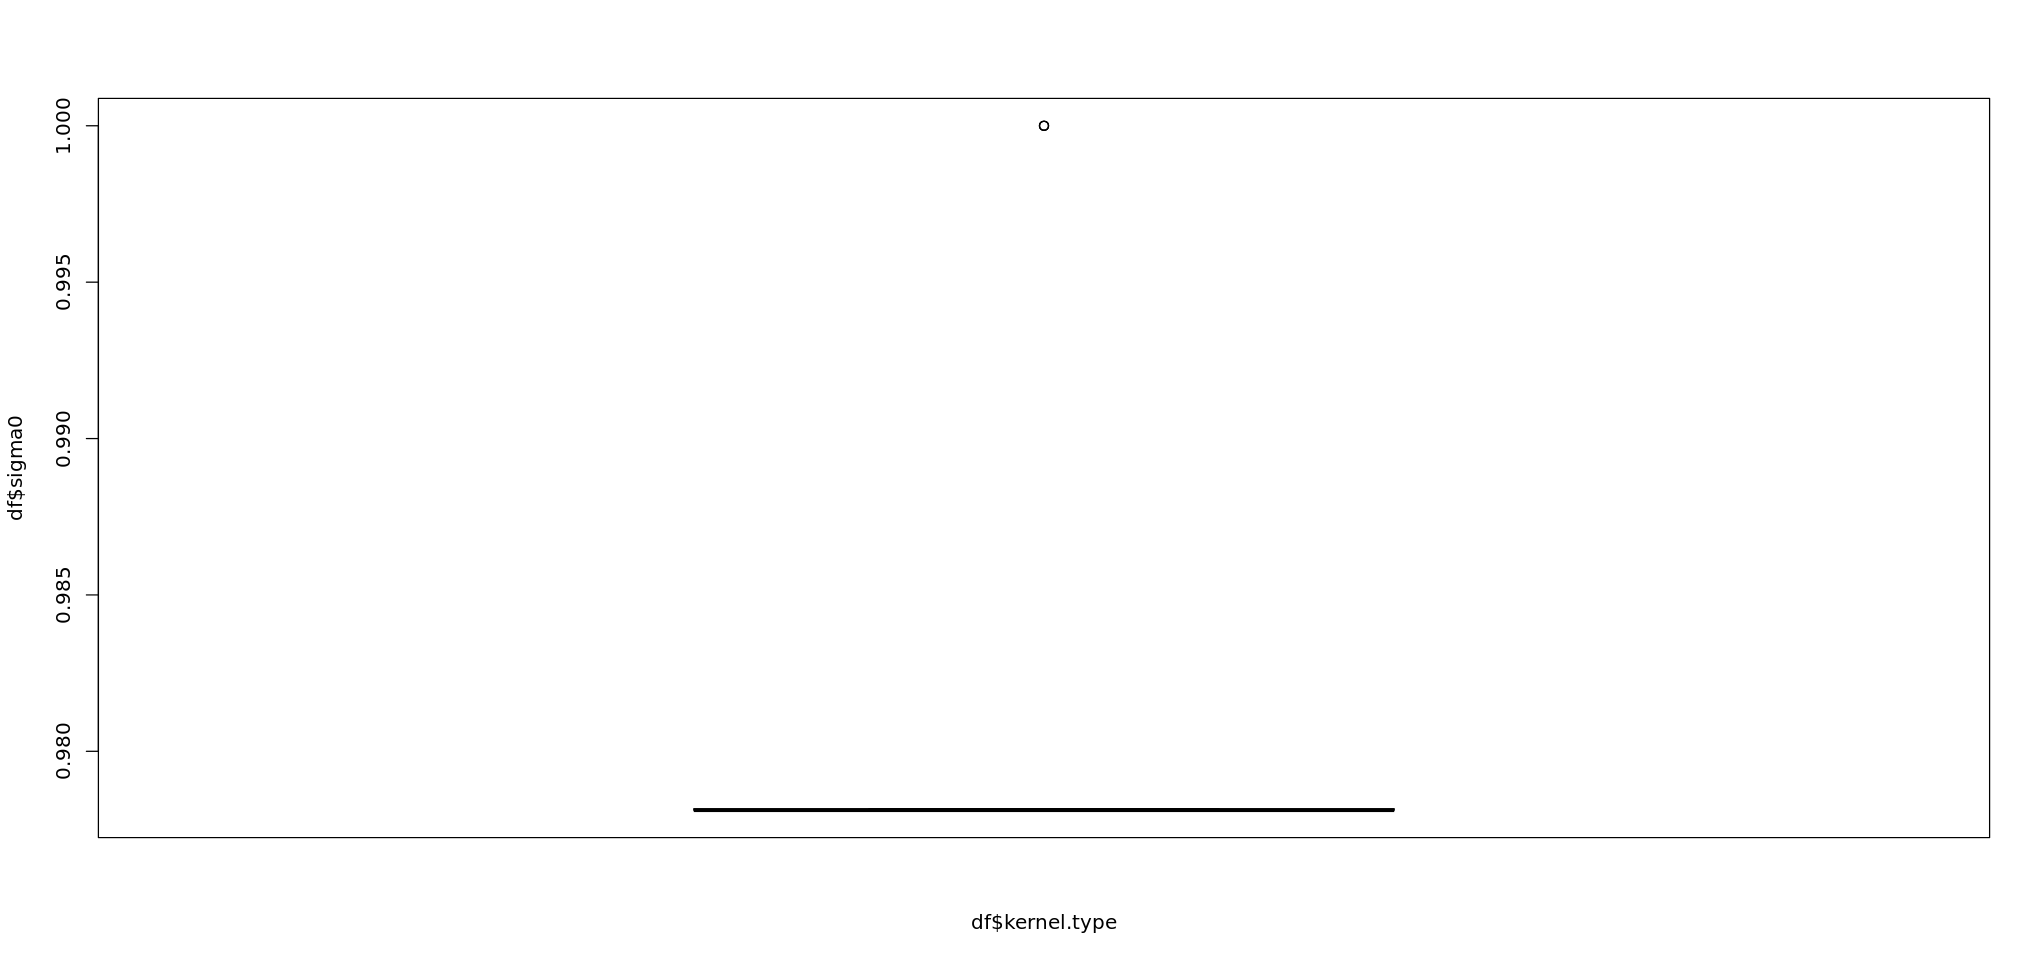

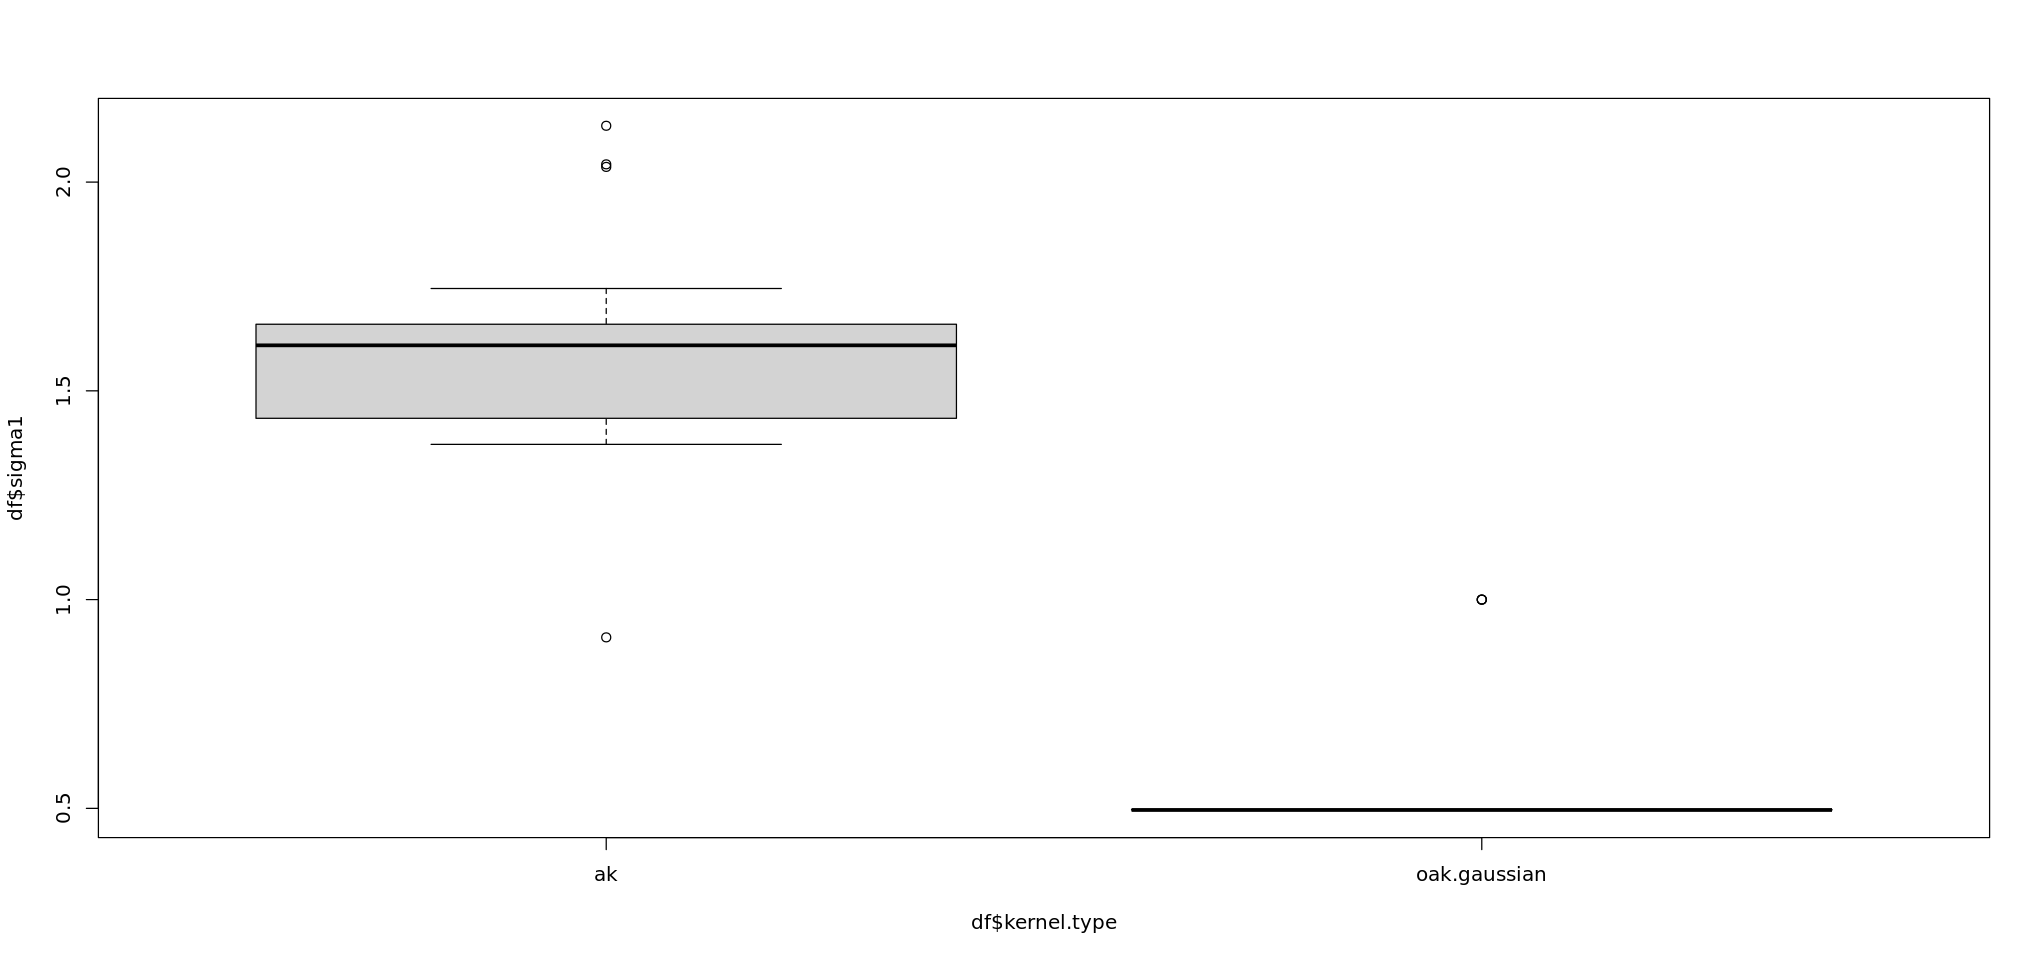

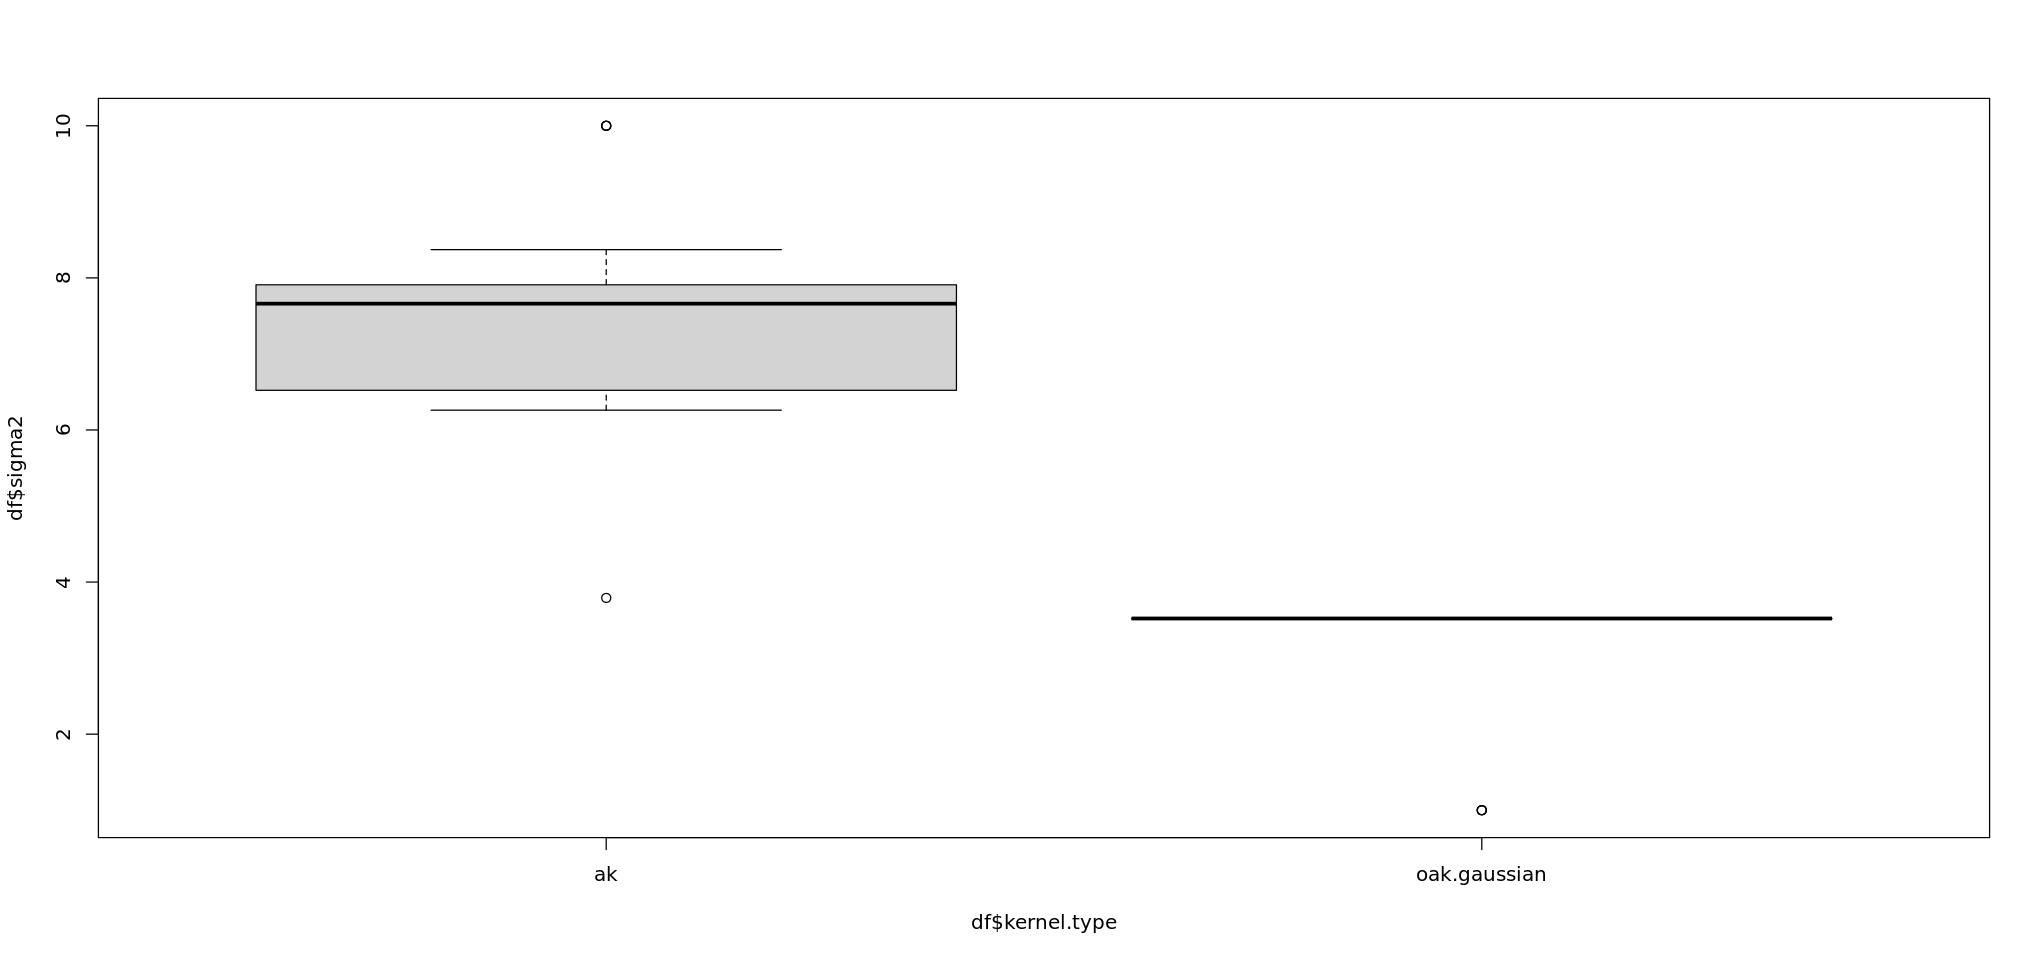

In [761]:
df <- df.result
df$ak$sigma0 <- NA
df$oak.gaussian$sigma0 <- df$oak.gaussian$sigma1
df$oak.gaussian$sigma1 <- df$oak.gaussian$sigma2
df$oak.gaussian$sigma2 <- df$oak.gaussian$sigma3
df$oak.gaussian$sigma3 <- NULL
df <- rbind(df$ak, df$oak.gaussian)
df[,2:7] <- lapply(df[,2:7], function(r) as.numeric(r))

options(repr.plot.width=17, repr.plot.height=8)
boxplot(df$sigma0 ~ df$kernel.type)
boxplot(df$sigma1 ~ df$kernel.type)
boxplot(df$sigma2 ~ df$kernel.type)

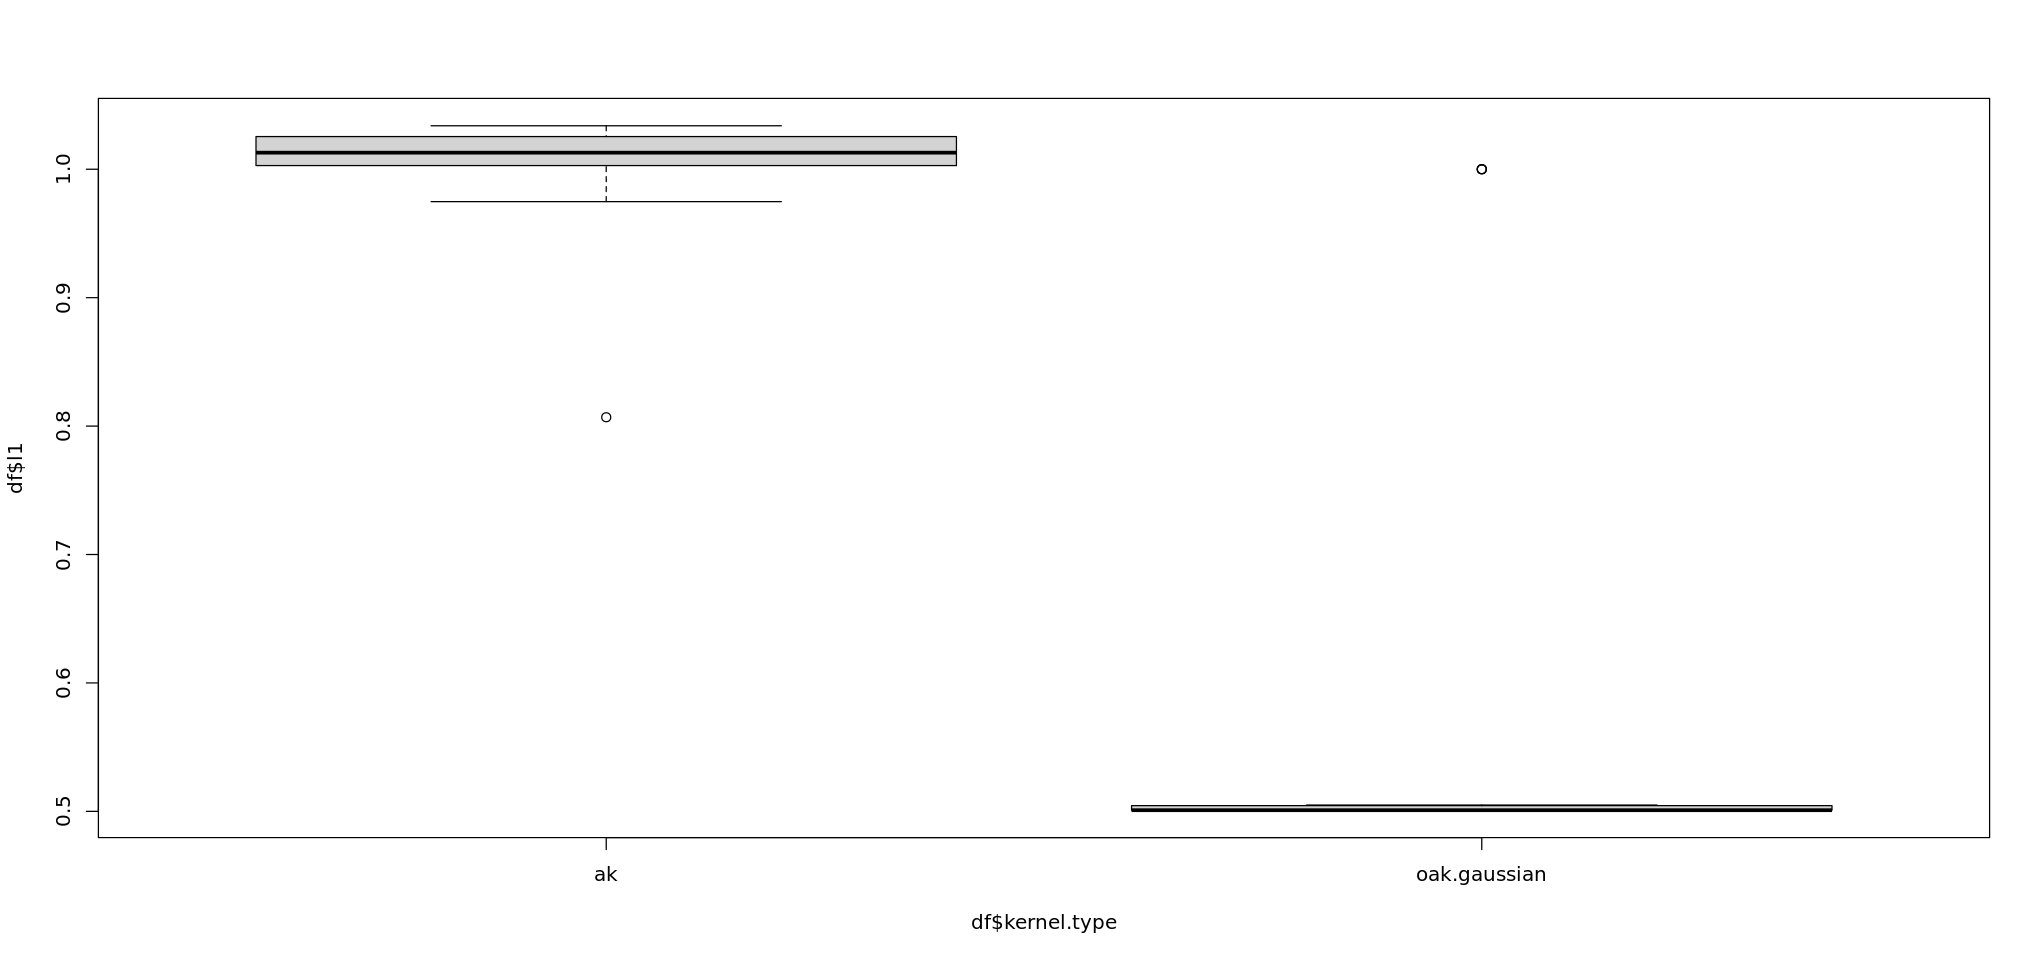

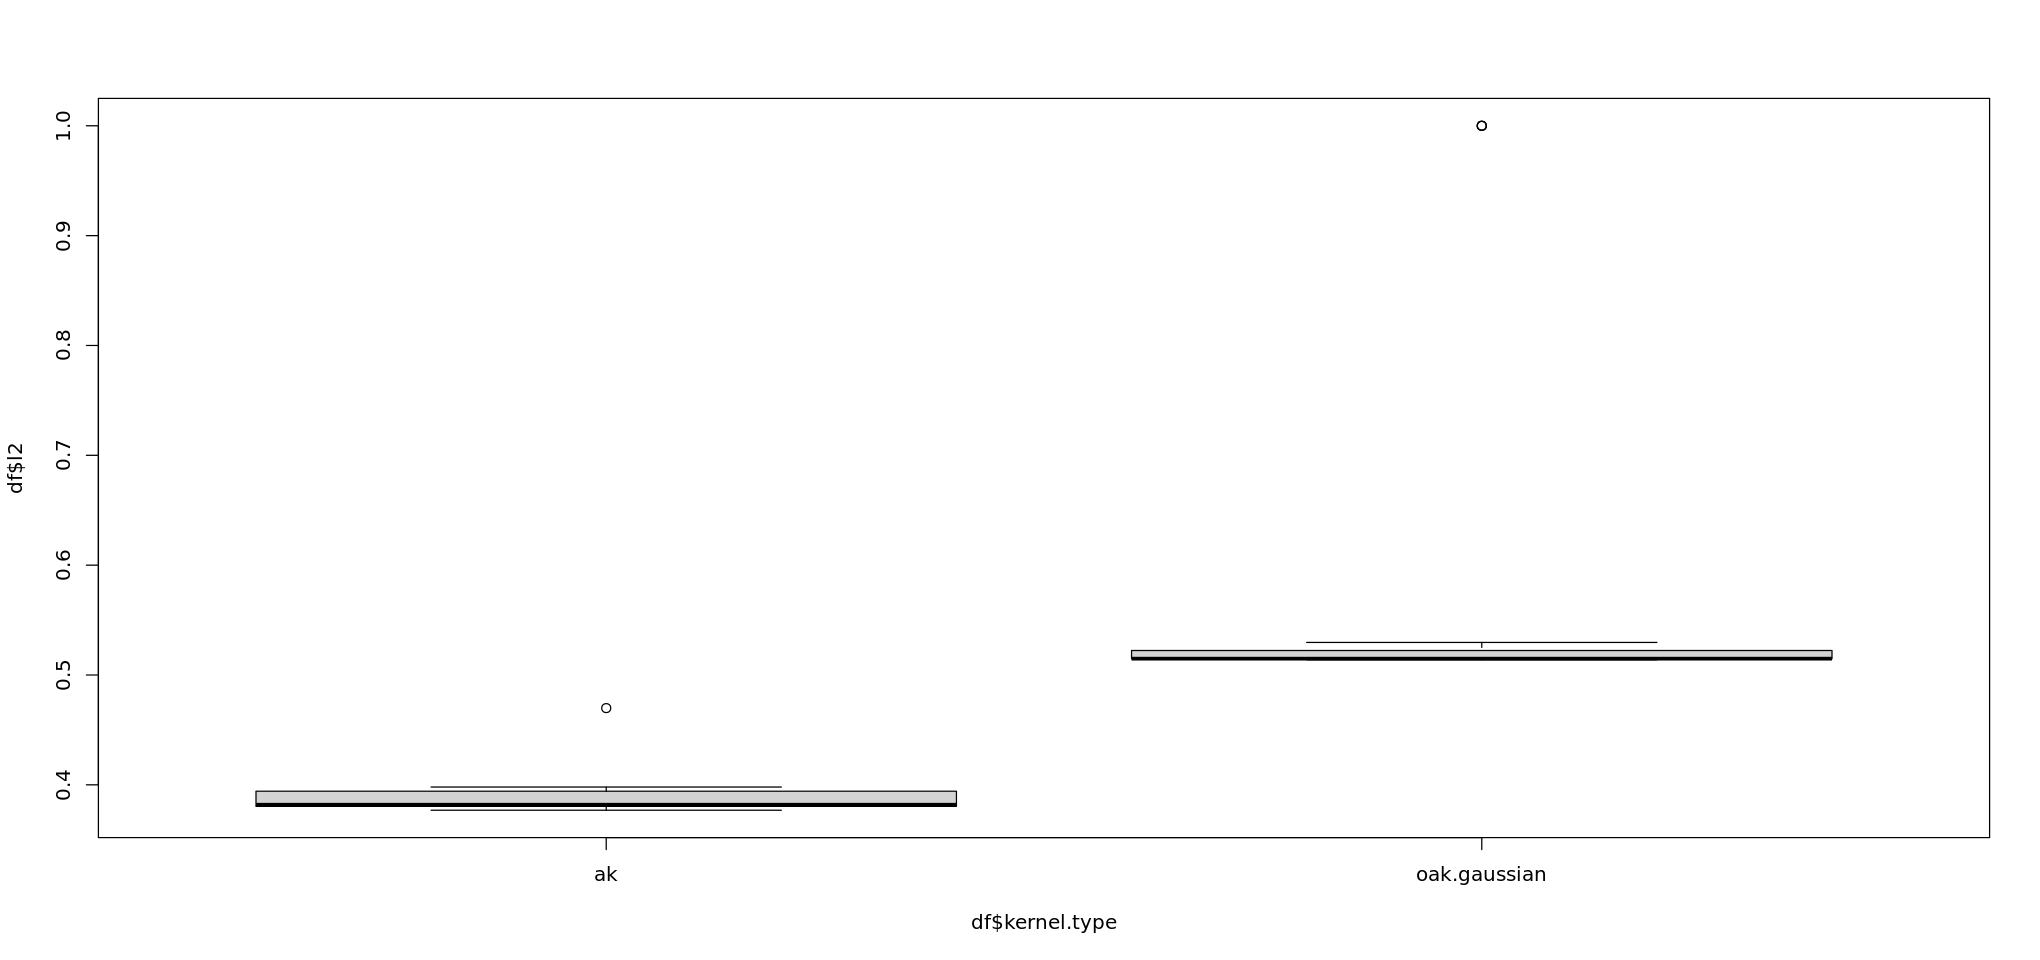

In [762]:
options(repr.plot.width=17, repr.plot.height=8)

boxplot(df$l1 ~ df$kernel.type)
boxplot(df$l2 ~ df$kernel.type)